In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Definición de constantes y parámetros del problema

In [2]:
c = 299792458.0

f0 = 1e9
er1 = 1
er2 = 16.0
ert = 4.0

eps0 = 8.854e-12
eps1 = 8.854e-12
eps2 = er1 * eps0
epst = np.sqrt(eps1 * eps2)

eta0 = 120 * np.pi
eta1 = eta0 / np.sqrt(er1)  
eta2 = eta0 / np.sqrt(er2)  
etat = eta0 / np.sqrt(ert)

# Lambda en la lámina a f0
lambda_m0 = c / (f0 * np.sqrt(epst / eps0))

# Espesor de la lámina (cuarto de onda)
d = lambda_m0 / 4


# Parte a

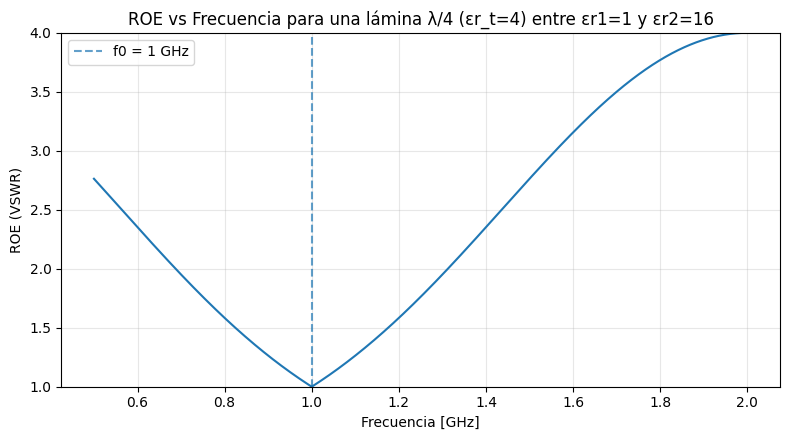

In [3]:
f = np.linspace(f0/2, 2*f0, 2001) 

beta_d = (np.pi/2.0) * (f / f0)
tan_bd = np.tan(beta_d)

Zin = etat * (eta2 + 1j * etat * tan_bd) / (etat + 1j * eta2 * tan_bd)

Gamma = (Zin - eta1) / (Zin + eta1)

ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))

# Graficar ROE vs frecuencia
plt.figure(figsize=(8, 4.5))
plt.plot(f/1e9, ROE)
plt.axvline(f0/1e9, linestyle='--', alpha=0.7, label='f0 = 1 GHz')
plt.ylim(1, min(5, np.nanmax(ROE)))   
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('ROE (VSWR)')
plt.title('ROE vs Frecuencia para una lámina λ/4 (εr_t=4) entre εr1=1 y εr2=16')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Parte b

f1 = 0.825 GHz
f2 = 1.175 GHz
BW = 350.2 MHz  (35.02% de f0)


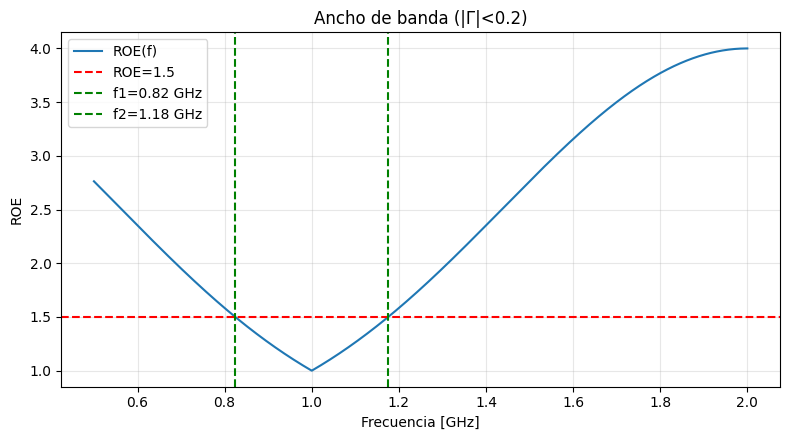

In [4]:
umbral_ROE = 1.5  # |Γ|<0.2  <=>  ROE<1.5
mask = ROE < umbral_ROE
idx = np.where(mask)[0]
splits = np.where(np.diff(idx) > 1)[0] + 1
tramos = np.split(idx, splits)
f0 = 1e9
tramo_ok = min(tramos, key=lambda t: abs(f[t].mean()-f0))
f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]
BW, BW_pct = f2 - f1, (f2 - f1)/f0*100

print(f"f1 = {f1/1e9:.3f} GHz")
print(f"f2 = {f2/1e9:.3f} GHz")
print(f"BW = {BW/1e6:.1f} MHz  ({BW_pct:.2f}% de f0)")

plt.figure(figsize=(8,4.5))
plt.plot(f/1e9, ROE, label='ROE(f)')
plt.axhline(umbral_ROE, color='r', ls='--', label='ROE=1.5')
plt.axvline(f1/1e9, color='g', ls='--', label=f'f1={f1/1e9:.2f} GHz')
plt.axvline(f2/1e9, color='g', ls='--', label=f'f2={f2/1e9:.2f} GHz')
plt.xlabel('Frecuencia [GHz]'); plt.ylabel('ROE'); plt.title('Ancho de banda (|Γ|<0.2)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()



# Parte C

εr_t = 2.5198, εr_n = 6.3496
d_t = 47.21 mm, d_n = 29.74 mm

f1 = 1.110 GHz
f2 = 1.464 GHz
BW = 354.4 MHz (35.44% de f0)



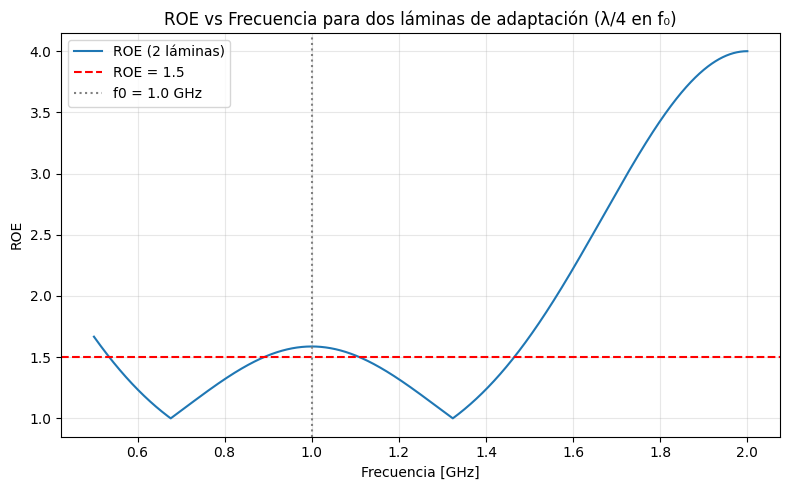

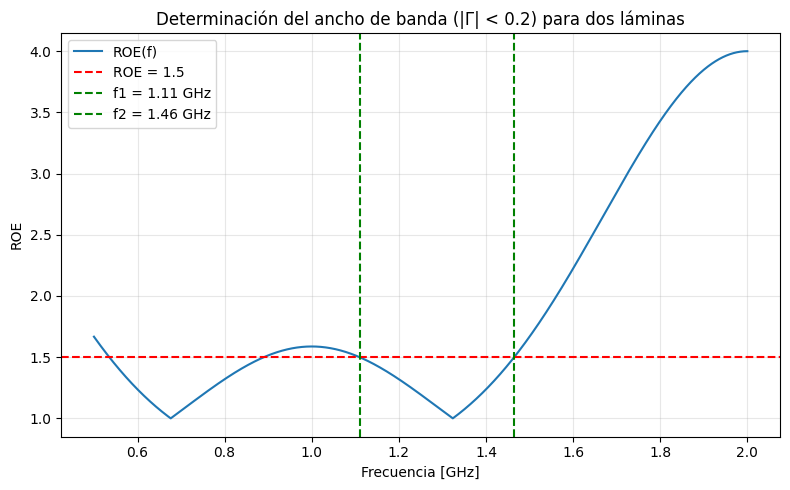

In [5]:
# --- Medios extremos ---
eta1 = eta0            # εr1 = 1
eta2 = eta0 / 4.0      # εr2 = 16

# --- Impedancias intermedias (progresión geométrica) ---
eta_t = eta1 * (eta2 / eta1) ** (1 / 3)
eta_n = eta1 * (eta2 / eta1) ** (2 / 3)

# --- Permitividades relativas y espesores (λ/4 en f0) ---
er_t = (eta0 / eta_t) ** 2
er_n = (eta0 / eta_n) ** 2

lambda0 = c / f0
d_t = lambda0 / (4 * np.sqrt(er_t))
d_n = lambda0 / (4 * np.sqrt(er_n))

print(f"εr_t = {er_t:.4f}, εr_n = {er_n:.4f}")
print(f"d_t = {d_t*1e3:.2f} mm, d_n = {d_n*1e3:.2f} mm\n")

# --- Rango de frecuencias ---
f = np.linspace(f0/2, 2*f0, 4001)
beta_t = 2*np.pi*f*np.sqrt(er_t)/c
beta_n = 2*np.pi*f*np.sqrt(er_n)/c

# --- Coeficientes de reflexión locales ---
Gamma12 = (eta_t - eta1) / (eta_t + eta1)
Gamma23 = (eta_n - eta_t) / (eta_n + eta_t)
Gamma34 = (eta2 - eta_n) / (eta2 + eta_n)

# --- Reflexión total ---
Gamma_tot = np.zeros_like(f, dtype=complex)

for i in range(len(f)):
    # Desde la última interfaz hacia el medio de entrada
    exp3 = np.exp(-2j * beta_n[i] * d_n)
    Gamma3ef = (Gamma34 + 0 * exp3) / (1 + Gamma34 * 0 * exp3)
    Gamma2ef = (Gamma23 + Gamma3ef * exp3) / (1 + Gamma23 * Gamma3ef * exp3)

    exp2 = np.exp(-2j * beta_t[i] * d_t)
    Gamma1ef = (Gamma12 + Gamma2ef * exp2) / (1 + Gamma12 * Gamma2ef * exp2)

    Gamma_tot[i] = Gamma1ef

# --- Cálculo de ROE y ancho de banda ---
Gamma_abs = np.abs(Gamma_tot)
ROE = (1 + Gamma_abs) / (1 - Gamma_abs)

umbral_ROE = 1.5
mask = ROE < umbral_ROE
idx = np.where(mask)[0]
splits = np.where(np.diff(idx) > 1)[0] + 1
tramos = np.split(idx, splits)
tramo_ok = min(tramos, key=lambda t: abs(f[t].mean() - f0))

f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]
BW = f2 - f1
BW_pct = BW / f0 * 100

print(f"f1 = {f1/1e9:.3f} GHz")
print(f"f2 = {f2/1e9:.3f} GHz")
print(f"BW = {BW/1e6:.1f} MHz ({BW_pct:.2f}% de f0)\n")

# --- Gráficos ---
plt.figure(figsize=(8,5))
plt.plot(f/1e9, ROE, label='ROE (2 láminas)')
plt.axhline(1.5, color='r', linestyle='--', label='ROE = 1.5')
plt.axvline(f0/1e9, color='gray', ls=':', label='f0 = 1.0 GHz')
plt.title('ROE vs Frecuencia para dos láminas de adaptación (λ/4 en f₀)')
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('ROE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(f/1e9, ROE, label='ROE(f)')
plt.axhline(umbral_ROE, color='r', ls='--', label='ROE = 1.5')
plt.axvline(f1/1e9, color='g', ls='--', label=f'f1 = {f1/1e9:.2f} GHz')
plt.axvline(f2/1e9, color='g', ls='--', label=f'f2 = {f2/1e9:.2f} GHz')
plt.title('Determinación del ancho de banda (|Γ| < 0.2) para dos láminas')
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('ROE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Parte d:
Graficar el ancho de banda en función del número n de láminas a insertar entre los dos medios.

n = 1:  f1 = 0.825 GHz,  f2 = 1.175 GHz,  BW = 350.6 MHz  (35.06% de f0)
n = 2:  f1 = 1.110 GHz,  f2 = 1.464 GHz,  BW = 354.4 MHz  (35.44% de f0)
n = 3:  f1 = 0.500 GHz,  f2 = 1.602 GHz,  BW = 1102.1 MHz  (110.21% de f0)
n = 4:  f1 = 0.500 GHz,  f2 = 1.683 GHz,  BW = 1183.1 MHz  (118.31% de f0)
n = 5:  f1 = 0.500 GHz,  f2 = 1.736 GHz,  BW = 1236.4 MHz  (123.64% de f0)
n = 6:  f1 = 0.500 GHz,  f2 = 1.774 GHz,  BW = 1274.2 MHz  (127.43% de f0)
n = 7:  f1 = 0.500 GHz,  f2 = 1.803 GHz,  BW = 1302.8 MHz  (130.28% de f0)
n = 8:  f1 = 0.500 GHz,  f2 = 1.825 GHz,  BW = 1324.9 MHz  (132.49% de f0)
n = 9:  f1 = 0.500 GHz,  f2 = 1.843 GHz,  BW = 1342.5 MHz  (134.25% de f0)
n = 10:  f1 = 0.500 GHz,  f2 = 1.857 GHz,  BW = 1356.8 MHz  (135.67% de f0)
n = 11:  f1 = 0.500 GHz,  f2 = 1.869 GHz,  BW = 1368.8 MHz  (136.88% de f0)
n = 12:  f1 = 0.500 GHz,  f2 = 1.879 GHz,  BW = 1378.9 MHz  (137.89% de f0)
n = 13:  f1 = 0.500 GHz,  f2 = 1.887 GHz,  BW = 1387.5 MHz  (138.75% de f0)
n = 14:  f1 = 0.500 GHz, 

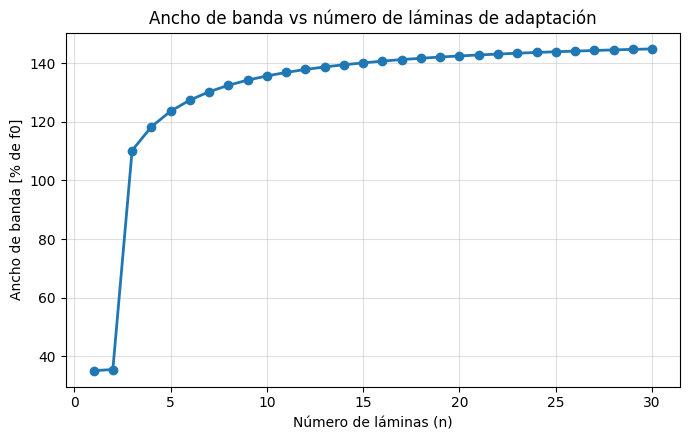

In [6]:
umbral_gamma = 0.2

def multilamina_ROE(n, f, f0, eta1, eta2):
    """
    Calcula ROE(f) y |Gamma|(f) para n láminas de adaptación entre dos medios.
    Cada lámina tiene espesor λ/4 a f0 y impedancia intermedia (progresión geométrica).
    """
    
    eta_layers = []  

    for i in range(1, n + 1):
        fraccion = i / (n + 1)
        eta_i = eta1 * (eta2 / eta1) ** fraccion
        eta_layers.append(eta_i)

    eta_total = [eta1] + eta_layers + [eta2]

    Gamma = np.zeros_like(f, dtype=complex)

    for i, freq in enumerate(f):
        Zin = eta_total[-1]
        for et in reversed(eta_total[:-1]):
            beta_d = (np.pi/2) * (freq / f0)  
            Zin = et * (Zin + 1j*et*np.tan(beta_d)) / (et + 1j*Zin*np.tan(beta_d))
        Gamma[i] = (Zin - eta1) / (Zin + eta1)

    ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))
    return ROE, Gamma


n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
BW_pct_list = []

for n in n_values:
    ROE, Gamma = multilamina_ROE(n, f, f0, eta1, eta2)

    mask = np.abs(Gamma) < umbral_gamma
    idx = np.where(mask)[0]

    splits = np.where(np.diff(idx) > 1)[0] + 1
    tramos = np.split(idx, splits)

    tramo_ok = min(tramos, key=lambda t: abs(f[t].mean() - f0))
    f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]

    BW_abs = f2 - f1
    BW_pct = (BW_abs / f0) * 100
    BW_pct_list.append(BW_pct)

    print(f"n = {n}:  f1 = {f1/1e9:.3f} GHz,  f2 = {f2/1e9:.3f} GHz,  "
          f"BW = {BW_abs/1e6:.1f} MHz  ({BW_pct:.2f}% de f0)")

# Gráfica de ancho de banda vs número de láminas
plt.figure(figsize=(7,4.5))
plt.plot(n_values, BW_pct_list, marker='o', linewidth=2)
plt.title('Ancho de banda vs número de láminas de adaptación')
plt.xlabel('Número de láminas (n)')
plt.ylabel('Ancho de banda [% de f0]')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


n=1: f1=0.825 GHz, f2=1.175 GHz, BW=350.6 MHz (35.06% f0)
n=2: f1=0.535 GHz, f2=0.890 GHz, BW=354.8 MHz (35.48% f0)
n=3: f1=0.500 GHz, f2=1.602 GHz, BW=1102.1 MHz (110.21% f0)
n=4: f1=0.500 GHz, f2=1.683 GHz, BW=1183.1 MHz (118.31% f0)
n=5: f1=0.500 GHz, f2=1.736 GHz, BW=1236.4 MHz (123.64% f0)
n=6: f1=0.500 GHz, f2=1.774 GHz, BW=1274.2 MHz (127.43% f0)
n=7: f1=0.500 GHz, f2=1.803 GHz, BW=1302.8 MHz (130.28% f0)
n=8: f1=0.500 GHz, f2=1.825 GHz, BW=1324.9 MHz (132.49% f0)
n=9: f1=0.500 GHz, f2=1.843 GHz, BW=1342.5 MHz (134.25% f0)
n=10: f1=0.500 GHz, f2=1.857 GHz, BW=1356.8 MHz (135.67% f0)
n=11: f1=0.500 GHz, f2=1.869 GHz, BW=1368.8 MHz (136.88% f0)
n=12: f1=0.500 GHz, f2=1.879 GHz, BW=1378.9 MHz (137.89% f0)
n=13: f1=0.500 GHz, f2=1.887 GHz, BW=1387.5 MHz (138.75% f0)
n=14: f1=0.500 GHz, f2=1.895 GHz, BW=1395.0 MHz (139.50% f0)
n=15: f1=0.500 GHz, f2=1.901 GHz, BW=1401.4 MHz (140.14% f0)
n=16: f1=0.500 GHz, f2=1.907 GHz, BW=1407.4 MHz (140.74% f0)
n=17: f1=0.500 GHz, f2=1.913 GHz, BW=

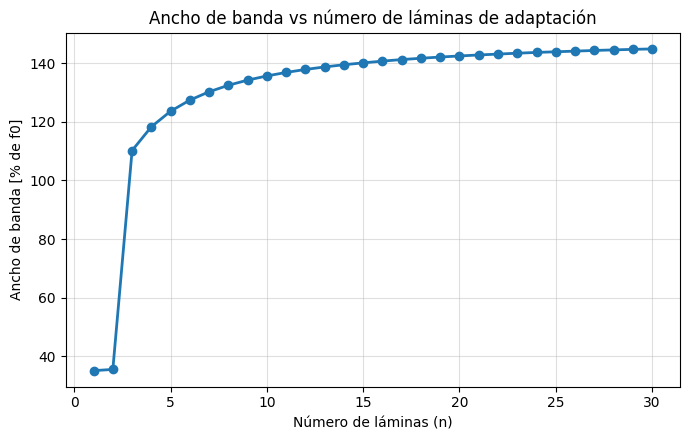

In [7]:
umbral_gamma = 0.2

def multilamina_ROE(n, f, f0, eta1, eta2):
    """Calcula ROE(f) y |Gamma|(f) para n láminas de adaptación entre dos medios."""
    eta_layers = [eta1 * (eta2 / eta1) ** (i / (n + 1)) for i in range(1, n + 1)]
    eta_total = [eta1] + eta_layers + [eta2]

    Gamma = np.zeros_like(f, dtype=complex)
    for i, freq in enumerate(f):
        Zin = eta_total[-1]
        for et in reversed(eta_total[:-1]):
            beta_d = (np.pi/2) * (freq / f0)
            Zin = et * (Zin + 1j*et*np.tan(beta_d)) / (et + 1j*Zin*np.tan(beta_d))
        Gamma[i] = (Zin - eta1) / (Zin + eta1)

    ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))
    return ROE, Gamma

n_values = list(range(1, 31))
BW_pct_list = []

for n in n_values:
    ROE, Gamma = multilamina_ROE(n, f, f0, eta1, eta2)
    mask = np.abs(Gamma) < umbral_gamma
    idx = np.where(mask)[0]

    if len(idx) == 0:
        BW_pct_list.append(0)
        continue

    splits = np.where(np.diff(idx) > 1)[0] + 1
    tramos = np.split(idx, splits)
    tramo_ok = max(tramos, key=len)  # ← tramo más ancho
    f1, f2 = f[tramo_ok][0], f[tramo_ok][-1]

    BW_abs = f2 - f1
    BW_pct = (BW_abs / f0) * 100
    BW_pct_list.append(BW_pct)

    print(f"n={n}: f1={f1/1e9:.3f} GHz, f2={f2/1e9:.3f} GHz, BW={BW_abs/1e6:.1f} MHz ({BW_pct:.2f}% f0)")

plt.figure(figsize=(7,4.5))
plt.plot(n_values, BW_pct_list, marker='o', linewidth=2)
plt.title('Ancho de banda vs número de láminas de adaptación')
plt.xlabel('Número de láminas (n)')
plt.ylabel('Ancho de banda [% de f0]')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
